**Võ Luyện**

**Trần Thị Vẹn**

**Nguyễn Thanh Tú**

# **STACK LTSM**

Stacked LSTMs are now a stable technique for challenging sequence prediction problems.

A Stacked LSTM architecture can be defined as an LSTM model comprised of multiple LSTM layers. An LSTM layer above provides a sequence output rather than a single value output to the LSTM layer below.

Specifically, one output per input time step, rather than one output time step for all input time steps.

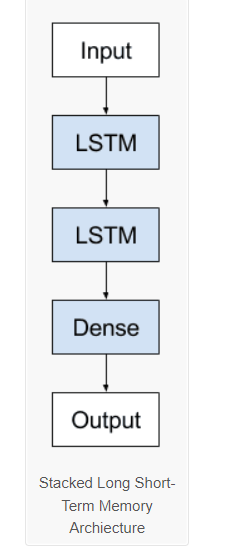


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import seaborn as sns
import torch

In [ ]:
# Load the dataset
data = pd.read_csv("AMZN.csv")

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
6252,2022-03-18,3136.260010,3231.879883,3120.219971,3225.010010,3225.010010,5141300
6253,2022-03-21,3222.419922,3261.679932,3191.060059,3229.830078,3229.830078,3326900
6254,2022-03-22,3236.110107,3323.340088,3233.979980,3297.780029,3297.780029,3204300
6255,2022-03-23,3274.100098,3327.399902,3253.739990,3268.159912,3268.159912,2790600


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6257 entries, 0 to 6256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6257 non-null   object 
 1   Open       6257 non-null   float64
 2   High       6257 non-null   float64
 3   Low        6257 non-null   float64
 4   Close      6257 non-null   float64
 5   Adj Close  6257 non-null   float64
 6   Volume     6257 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 342.3+ KB


The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

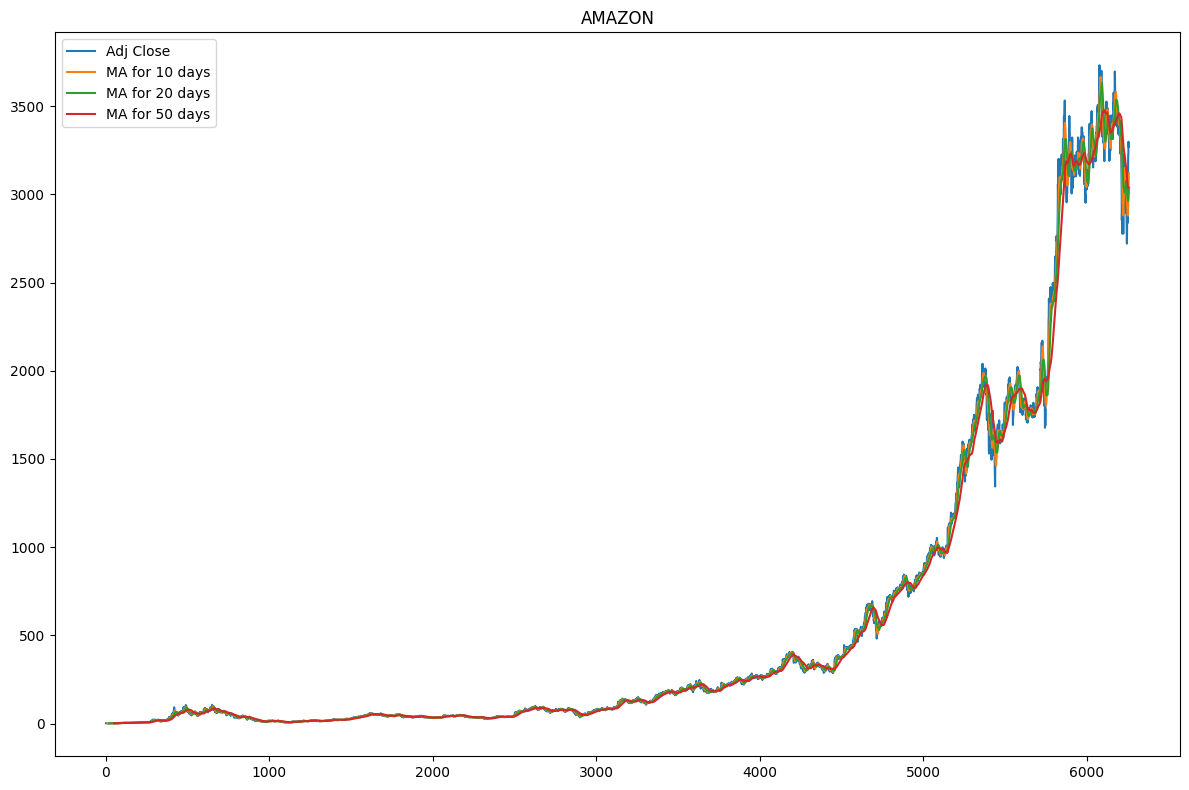

In [ ]:
ma_day = [10, 20, 50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Adj Close'].rolling(ma).mean()

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)

data[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax)
ax.set_title('AMAZON')

fig.tight_layout()

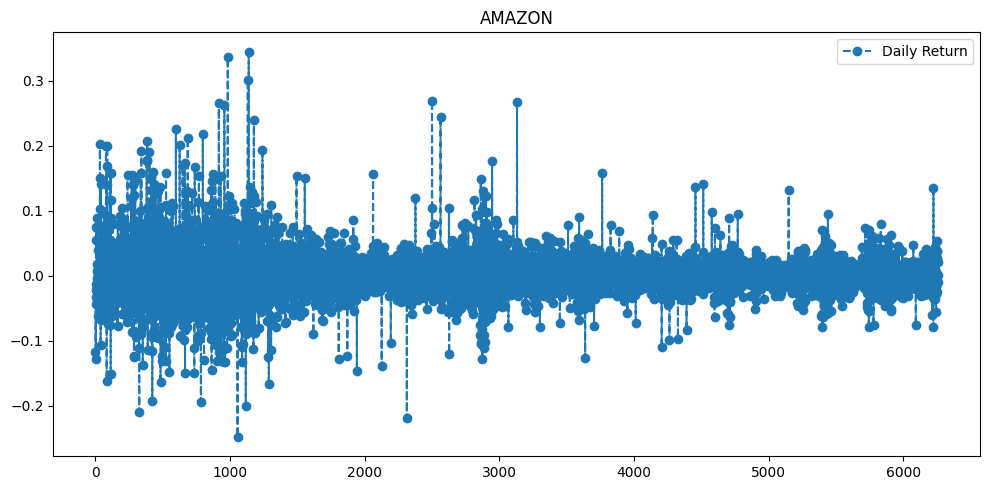

In [ ]:
# Calculate daily return percentage for Amazon
data['Daily Return'] = data['Adj Close'].pct_change()

# Plot daily return for Amazon
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

data['Daily Return'].plot(ax=ax, legend=True, linestyle='--', marker='o')
ax.set_title('AMAZON')

fig.tight_layout()

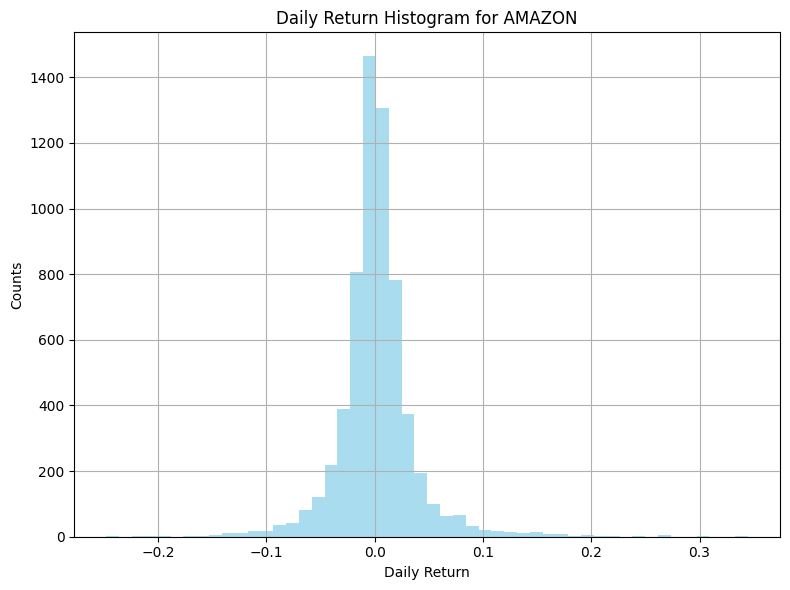

In [ ]:
plt.figure(figsize=(8, 6))

# Plot histogram of daily returns for Amazon
data['Daily Return'].hist(bins=50, color='skyblue', alpha=0.7)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('Daily Return Histogram for AMAZON')

plt.tight_layout()
plt.show()

In [ ]:
# Preprocessing
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

# Split data into input and target
X = []
y = []

In [ ]:
sequence_length = 5  # Adjust this based on your requirements
for i in range(len(data_normalized) - sequence_length):
    X.append(data_normalized[i:i+sequence_length])
    y.append(data_normalized[i+sequence_length])

X = np.array(X)
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
# Define the model
class StackLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StackLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_stack = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm_stack(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Instantiate the model
input_size = 5  # Number of features
hidden_size = 64  # Adjust this based on your requirements
num_layers = 2  # Adjust this based on your requirements
output_size = 5  # Number of output features (same as input size for this case)
model = StackLSTM(input_size, hidden_size, num_layers, output_size)

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training the model
num_epochs = 100  # Adjust this based on your requirements
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [10/100], Loss: 0.0035
Epoch [20/100], Loss: 0.0030
Epoch [30/100], Loss: 0.0026
Epoch [40/100], Loss: 0.0016
Epoch [50/100], Loss: 0.0012
Epoch [60/100], Loss: 0.0009
Epoch [70/100], Loss: 0.0009
Epoch [80/100], Loss: 0.0008
Epoch [90/100], Loss: 0.0008
Epoch [100/100], Loss: 0.0007
Test Loss: 0.0104


# AirPassengers.csv

In [ ]:
def plot_decompose(decompose_result):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(12,20))
    decompose_result.observed.plot(legend=False,ax=ax1,fontsize = 20,grid=True,linewidth = 3)
    ax1.set_ylabel("Observed",fontsize = 20)
    decompose_result.trend.plot(legend=False,ax=ax2,fontsize = 20,grid=True,linewidth = 3)
    ax2.set_ylabel("Trend",fontsize = 20)
    decompose_result.seasonal.plot(legend=False,ax=ax3,fontsize = 20,grid=True,linewidth = 3)
    ax3.set_ylabel("Seasonal",fontsize = 20)
    decompose_result.resid.plot(legend=False,ax=ax4,fontsize = 20,grid=True,linewidth = 3)
    ax4.set_ylabel("Residual",fontsize = 20)

In [ ]:
flight_data = pd.read_csv('AirPassengers.csv')
cm = sns.light_palette("green", as_cmap=True)
flight_data.head(20).style.background_gradient(cmap=cm)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [ ]:
print(flight_data.describe())
print('-'*40)
print(flight_data.tail())

       #Passengers
count   144.000000
mean    280.298611
std     119.966317
min     104.000000
25%     180.000000
50%     265.500000
75%     360.500000
max     622.000000
----------------------------------------
       Month  #Passengers
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432


In [ ]:
flight_data.shape

(144, 2)

In [ ]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


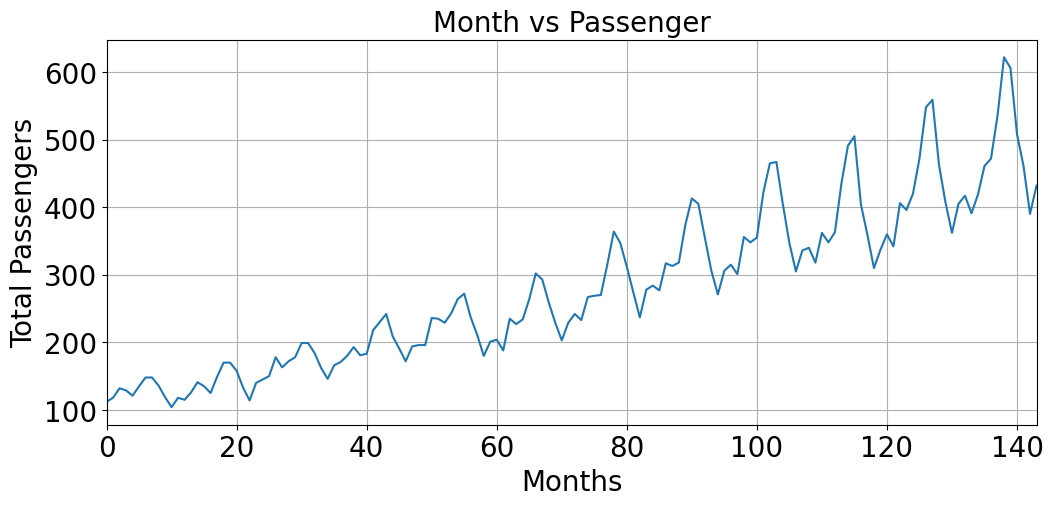

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(flight_data['#Passengers'])

In [ ]:
flight_data['#Passengers']

0      112
1      118
2      132
3      129
4      121
      ... 
139    606
140    508
141    461
142    390
143    432
Name: #Passengers, Length: 144, dtype: int64

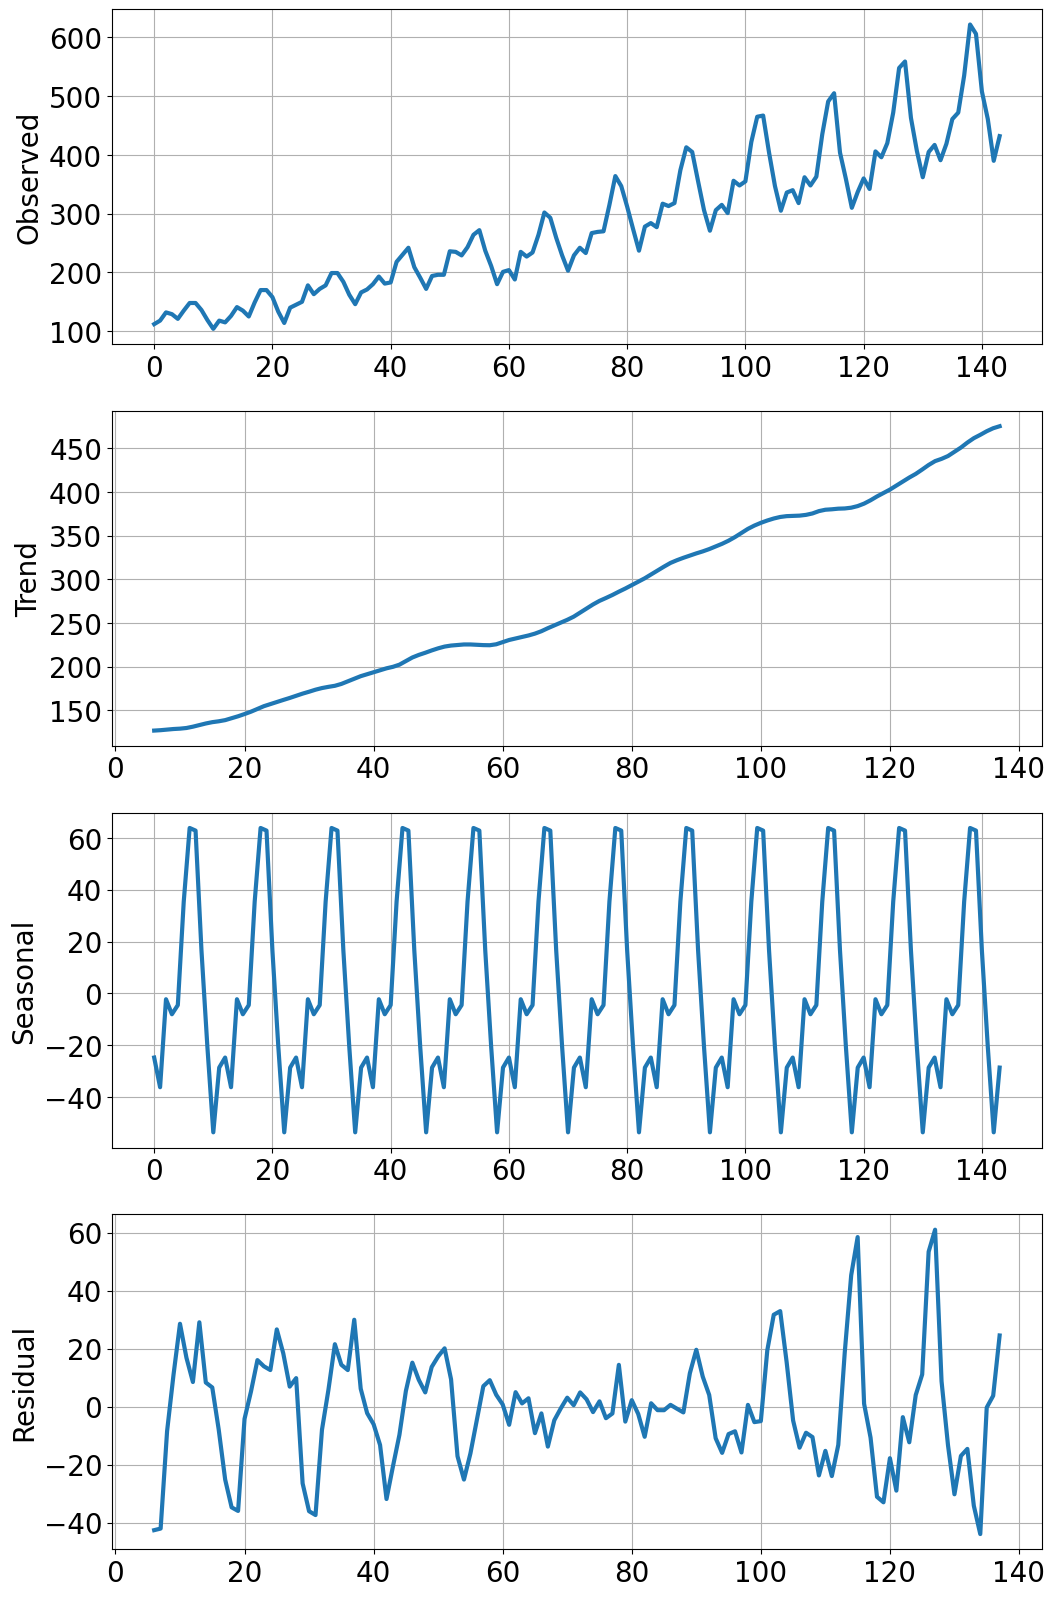

In [ ]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(flight_data['#Passengers'], period=12)
plot_decompose(decomposition)

In [ ]:
all_data = flight_data['#Passengers'].values.astype(float)
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


In [ ]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [ ]:
print(len(train_data))
print(len(test_data))

132
12


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [ ]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [ ]:
train_window = 12

In [ ]:
def create_inout_sequences(input_data, window):
    inout_seq = []
    L = len(input_data)
    for i in range(L-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window:i+window+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [ ]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [ ]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out[:,-1,:])
        return predictions[-1]

In [ ]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
epochs = 500

for epoch in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()

    if epoch % 25 == 1:
        print(f'Epoch: {epoch+1:3} Loss: {loss.item():10.8f}')

print(f'Epoch: {epochs:3} Loss: {loss.item():10.8f}')


Epoch:   2 Loss: 0.04757383
Epoch:  27 Loss: 0.00014324
Epoch:  52 Loss: 0.00302569
Epoch:  77 Loss: 0.00217701
Epoch: 102 Loss: 0.02235310
Epoch: 127 Loss: 0.00470535
Epoch: 152 Loss: 0.00322708
Epoch: 177 Loss: 0.00135238
Epoch: 202 Loss: 0.00006615
Epoch: 227 Loss: 0.00071473
Epoch: 252 Loss: 0.00000004
Epoch: 277 Loss: 0.00015876
Epoch: 302 Loss: 0.00211181
Epoch: 327 Loss: 0.00413471
Epoch: 352 Loss: 0.00006823
Epoch: 377 Loss: 0.00000129
Epoch: 402 Loss: 0.00169445
Epoch: 427 Loss: 0.00000538
Epoch: 452 Loss: 0.00014182
Epoch: 477 Loss: 0.00011854
Epoch: 500 Loss: 0.00006251


In [ ]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [ ]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        test_inputs.append(model(seq).item())

In [ ]:
test_inputs[fut_pred:]

[0.5371503829956055,
 0.6494584679603577,
 0.6204246878623962,
 0.39950352907180786,
 0.22628135979175568,
 0.3907228112220764,
 0.7715470194816589,
 0.8903564810752869,
 0.6063781380653381,
 0.3786811828613281,
 0.17575405538082123,
 0.41822463274002075]

In [ ]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)
x = np.arange(132, 144, 1)
print(x)

[[453.70171213]
 [479.25180146]
 [472.64661649]
 [422.38705286]
 [382.97900935]
 [420.38943955]
 [507.02694693]
 [534.05609944]
 [469.45102641]
 [417.6499691 ]
 [371.4840476 ]
 [426.64610395]]
[132 133 134 135 136 137 138 139 140 141 142 143]


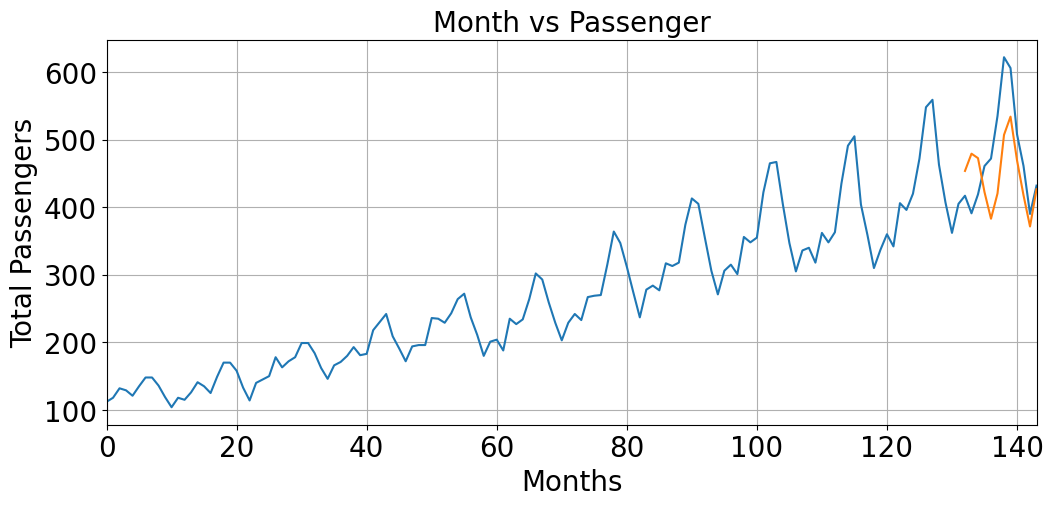

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(flight_data['#Passengers'])
plt.plot(x,actual_predictions)

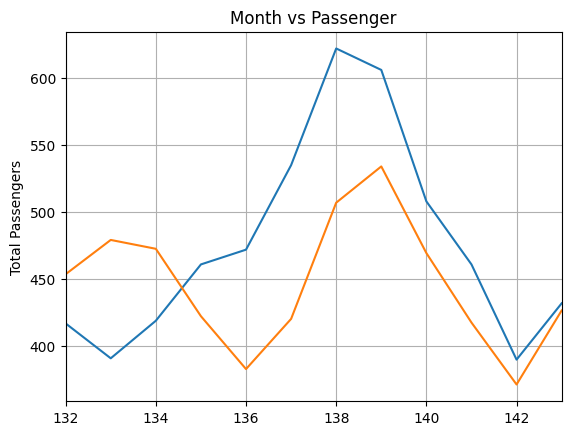

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['#Passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

In [ ]:
flight_data['#Passengers'][:-train_window]
train_df = pd.DataFrame(flight_data['#Passengers'][:-train_window])
actual_df = pd.DataFrame(actual_predictions)
actual_df.columns = ['#Passengers']
new_predict = pd.concat([train_df,actual_df]).reset_index(drop=True)

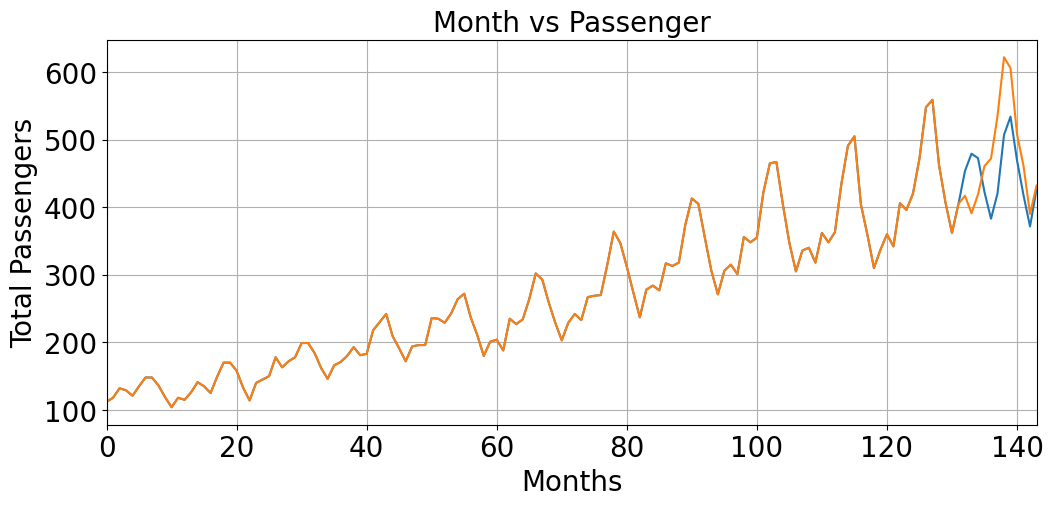

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Month vs Passenger',fontsize = 20)
plt.ylabel('Total Passengers',fontsize = 20)
plt.xlabel('Months',fontsize = 20)
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(new_predict)
plt.plot(flight_data['#Passengers'])

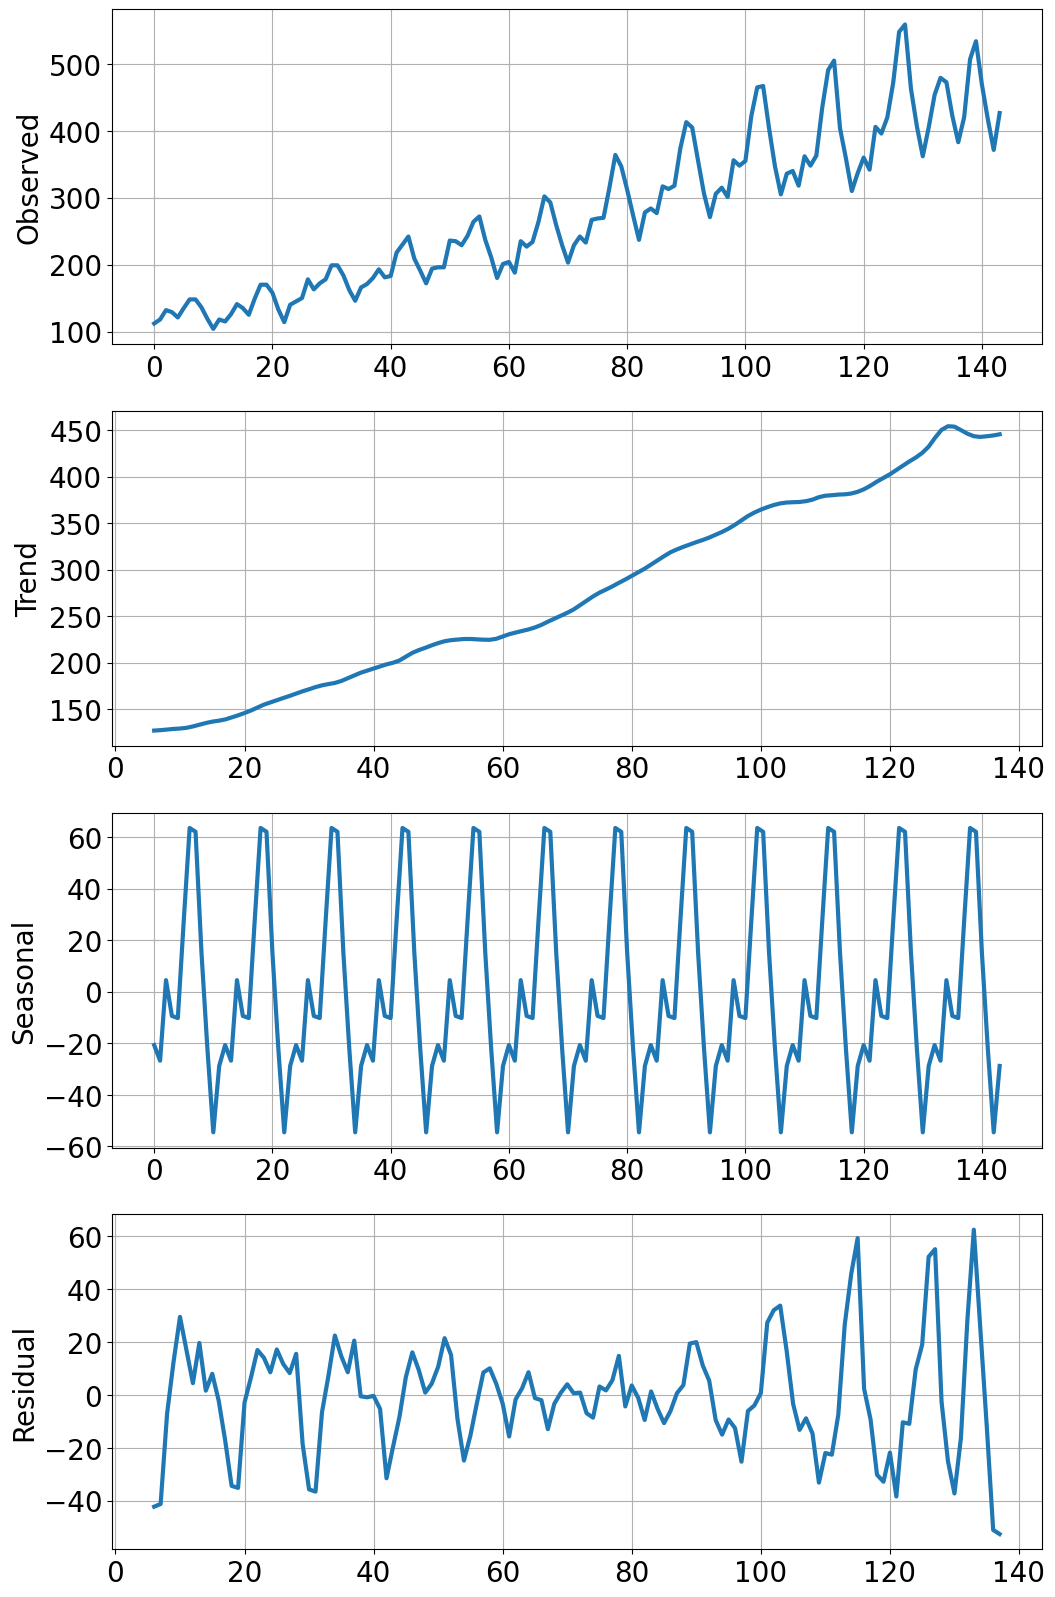

In [ ]:
decomposition = seasonal_decompose(new_predict, period=12)
plot_decompose(decomposition)